In [100]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from math import ceil, log, exp
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors


tf.keras.utils.set_random_seed(seed=100)

## AutoEncoder 

In [101]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, x_train):
        super().__init__()
        self.encoder = self.encoder_model()
        self.decoder = self.decoder_model()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.train_data = x_train
        

    def encoder_model(self):
        encoder_inputs = keras.Input(shape=(11,)) # the shape is the number of dimensions and the length of data that will be put in. 
        # i.e. 6dims and 1 data points
        
        

        encoded = layers.Dense(9, activation='tanh')(encoder_inputs)
        encoded = layers.Dense(7, activation='tanh')(encoded)
        encoded = layers.Dense(5, activation='tanh')(encoded)
        latent_space = layers.Dense(3, activation='tanh')(encoded) # this is the latent space (the output of the encoder)
        
        encoder = keras.Model(encoder_inputs, latent_space) # this defines the model in the keras computational graph
        encoder.compile(optimizer='Adam', loss='mse') # the compile step of the keras model
        encoder.summary()
        return encoder # returns the compiled model
    
    def decoder_model(self):
        decoder_inputs = keras.Input(shape=(3,)) # these are the inputs of the decoder (3dims (the latent space), 1 number of data points)
        decoded = layers.Dense(5, activation='tanh')(decoder_inputs)
        decoded = layers.Dense(7, activation='tanh')(decoded)
        decoded = layers.Dense(9, activation='tanh')(decoded)     
        output_space = layers.Dense(11, activation='sigmoid')(decoded) # the output (decoded latent space, should be the inputs)
        
        decoder = keras.Model(decoder_inputs, output_space) # defining the decoder as a Model
        decoder.compile(optimizer='Adam', loss='mse') # compiling the model
        decoder.summary()
        return decoder # returning the compiled model
    
    
    
    def train_step(self, data): # as we have two parts of the model, we have to define how the model should be trained to access the latent space
        with tf.GradientTape() as tape:
            latent_output = self.encoder(data)
            reconstructed_data = self.decoder(latent_output)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mean_squared_logarithmic_error(data, reconstructed_data)))
            total_loss = reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {'total_loss': self.total_loss_tracker.result(),
                'reconstruction_loss': self.reconstruction_loss_tracker.result()}

## Preprocessing Functions

In [102]:
class preprocessing:

    def map_unique_values(self, arr):
        unique_values = list(set(arr))
        unique_values.sort() 
        value_to_number_mapping = {value: i + 1 for i, value in enumerate(unique_values)}
        mapped_array = np.array([value_to_number_mapping[value] for value in arr])
        return mapped_array
    
    def map_unique_values_to_columns(self, np_array):
        mapped_columns = []
        for col_idx in range(np_array.shape[1]):
            mapped_column = self.map_unique_values(np_array[:, col_idx])
            mapped_columns.append(mapped_column)
        return np.array(mapped_columns).T
    
    
    def min_max(array):
        min_val = np.min(array, axis=0)
        max_val = np.max(array, axis=0)
        normalized_array = (array - min_val) / (max_val - min_val)
        return normalized_array


    def min_max_odd_columns(array):
        normalized_array = np.empty_like(array)
        for i in range(array.shape[1]):
            if i % 2 != 0:  # Even columns, just copy
                normalized_array[:, i] = array[:, i]
            else:  # Odd columns, perform min-max normalization
                min_val = np.min(array[:, i])
                max_val = np.max(array[:, i])
                normalized_array[:, i] = (array[:, i] - min_val) / (max_val - min_val)
        return normalized_array



## K-means Clustering

In [103]:
class clustering:

    def assign_clusters_find_distances(self, new_data, centroids):
            # Calculate distances to centroids
            distances = np.linalg.norm(new_data[:, np.newaxis] - centroids, axis=2)
            
            # Assign each point to the closest centroid
            cluster_assignment = np.argmin(distances, axis=1)
            
            # Get distances to the closest centroid
            min_distances = np.min(distances, axis=1)
            
            return cluster_assignment, min_distances


    def kmean_clustering_with_distances(self, data, num_clusters):
        from sklearn.cluster import KMeans
        
    
        
        num_columns = data.shape[1]
        centroids_list = []
        assignment_distances_list = []
        
        # Iterate over each column
        for i in range(num_columns):
            # Remove the i-th column from the data
            data_subset = np.delete(data, i, axis=1)
            
            # Perform K-means clustering
            kmeans = kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(data_subset)
            
            # Get cluster centroids
            centroids = kmeans.cluster_centers_
            centroids_list.append(centroids)
            
            # Assign clusters and distances
            cluster_assignment, distances = self.assign_clusters_find_distances(data_subset, centroids)
            assignment_distances_list.append(cluster_assignment)
            assignment_distances_list.append(distances)
        
        # Stack centroids into a single array
        stacked_centroids = np.stack(centroids_list, axis=1)
    
        # Stack assignments and distances into a single array
        stacked_assignment_distances = np.column_stack(assignment_distances_list)
        
        return stacked_centroids, stacked_assignment_distances




    

    def kmeans_clustering_with_distances_new_data(self, stacked_centroids, data): 
            num_columns = stacked_centroids.shape[1]
            assignment_distances_list = []
            
            # Iterate over each column
            for i in range(num_columns):
                # Get the centroids for the current iteration
                centroids = stacked_centroids[:, i, :]
                
                # Remove the i-th column from the data
                data_subset = np.delete(data, i, axis=1)
                
                # Assign clusters and distances using the provided centroids
                cluster_assignment, distances = self.assign_clusters_find_distances(data_subset, centroids)
                assignment_distances_list.append(cluster_assignment)
                assignment_distances_list.append(distances)
            
            # Stack assignments and distances into a single array
            assignment_distances = np.column_stack(assignment_distances_list)
            
            return assignment_distances





## Data Analysis Functions

In [104]:
class data_analysis:

    def calculate_gradient(self, x, y):
        if len(x) != len(y):
            raise ValueError("Arrays must be of the same length")
        
        # Perform linear regression to find the slope (gradient)
        m, _ = np.polyfit(x, y, 1)
        
        return m

    def calculate_average_grad(self, data_set1, data_set2):
        gradients = []
        for i in range(data_set1.shape[1]):
            gradient = self.calculate_gradient(data_set1[:, i], data_set2[:, i])
            gradients.append(gradient)
        
        gradients = np.array(gradients)
        average_gradient = np.mean(gradients)
        
        return gradients, average_gradient


    def calculate_r_square(self, array1, array2):
            if array1.shape[1] != array2.shape[1]:
                raise ValueError("Arrays must have the same number of columns")
            
            r_squared_values = []
            for i in range(array1.shape[1]):
                correlation_matrix = np.corrcoef(array1[:, i], array2[:, i])
                correlation_coefficient = correlation_matrix[0, 1]
                r_squared = correlation_coefficient ** 2
                r_squared_values.append(r_squared)
        
            r_squared_values = np.array(r_squared_values)
            average_r_squared = np.mean(r_squared_values)
            
            return r_squared_values, average_r_squared
    
    def plot_hexbin_log_frequency(x, y, xlabel="", ylabel="", title="", gridsize=100, cmap='viridis', colorbar=True):
        """
        Function to create a hexbin plot with log-scaled frequency using Matplotlib.
        """
        plt.figure(figsize=(8, 6))
        
        # Calculate the hexbin frequencies
        hb = plt.hexbin(x, y, gridsize=gridsize, cmap=cmap)
        counts = hb.get_array()
        nonzero_counts = counts[counts != 0]
        
        # Set the norm to LogNorm with vmin=0
        norm = mcolors.LogNorm(vmin=1, vmax=nonzero_counts.max())
        hb = plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, norm=norm)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        
        if colorbar:
            plt.colorbar(hb, label='log(count)')
        
        plt.show()

## Preprocessing 

In [105]:
x_data_raw = np.loadtxt('train4 .csv',delimiter = ',') #import of data as numpy array

In [106]:
#seperate categorical and continuous

categorical_data = np.delete(x_data_raw, 5, axis=1)
x6 = x_data_raw[:, 5]



In [107]:
print(type(mapped_min_max))

<class 'numpy.ndarray'>


In [108]:
#create instances for classes
preprocessor = preprocessing()
Cluster = clustering()
Analyse = data_analysis()

In [109]:
#Preprocess Categorical Data

#apply even spacing

mapped = preprocessor.map_unique_values_to_columns(categorical_data)

#normalise 
mapped_min_max = preprocessing.min_max(mapped)

#cluster
centroids, clustered = Cluster.kmean_clustering_with_distances(mapped_min_max, 10)

#add min max to cluster number
normalised_clustered = preprocessing.min_max_odd_columns(clustered)

print(normalised_clustered)





[[0.44444444 0.089851   0.88888889 ... 0.10202549 0.66666667 0.08914823]
 [0.11111111 0.25710347 0.         ... 0.23100372 0.55555556 0.23470316]
 [0.44444444 0.04883137 0.88888889 ... 0.15936334 0.66666667 0.14677303]
 ...
 [0.33333333 0.21887122 0.77777778 ... 0.2127822  0.11111111 0.21588971]
 [0.11111111 0.17342957 0.33333333 ... 0.21553291 0.66666667 0.23521337]
 [0.44444444 0.05476121 0.88888889 ... 0.07720942 0.66666667 0.07693073]]


In [110]:
#Preprocess Continuous Data

log_x6 = np.log10(x6)
x6_logged_normalized = preprocessing.min_max(log_x6)


In [111]:
Input_data = np.column_stack((normalised_clustered, x6_logged_normalized))

In [112]:
df = pd.DataFrame(clustered, columns=['1', '2', '3','4','5','6','7','8','9','10'])
df.to_csv('Clustered input') 

In [113]:
x_train = Input_data
#x_test = Input_data[ceil(0.8*len(Input_data)):] change this to validation

## Train AutoEncoder

In [114]:
#Train AutoEncoder #after changing all test stuff, check that auto encoder still runs without test bit

AutoEncoder = AutoEncoder(x_train)
AutoEncoder.compile(optimizer=keras.optimizers.Adam())
AutoEncoder.fit(x_train, epochs= 2000 , batch_size=200)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_22 (Dense)            (None, 9)                 108       
                                                                 
 dense_23 (Dense)            (None, 7)                 70        
                                                                 
 dense_24 (Dense)            (None, 5)                 40        
                                                                 
 dense_25 (Dense)            (None, 3)                 18        
                                                                 
Total params: 236 (944.00 Byte)
Trainable params: 236 (944.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_7"
____

## Analyse Training 

In [115]:
#Run with Trianing Data

latent_space_representation = AutoEncoder.encoder.predict(Input_data)

Output_data = AutoEncoder.decoder.predict(latent_space_representation)

6250/6250 [==============================] - 5s 862us/step


In [116]:
#Find Reconstruction Loss
Reconstruction_loss = np.mean(np.square(x_train - Output_data), axis = 1)
Threshold = np.percentile(Reconstruction_loss, 99.0)
print(Threshold)


0.033014923164095586


In [117]:
#Find Gradients
all_gradients, average_gradient = Analyse.calculate_average_grad(Input_data, Output_data)
print(average_gradient)


0.7524148443303119


In [118]:
#Find r^2 values
all_r_squared, average_r_squared = Analyse.calculate_r_square(Input_data, Output_data)
print(average_r_squared)

0.7600402148942131


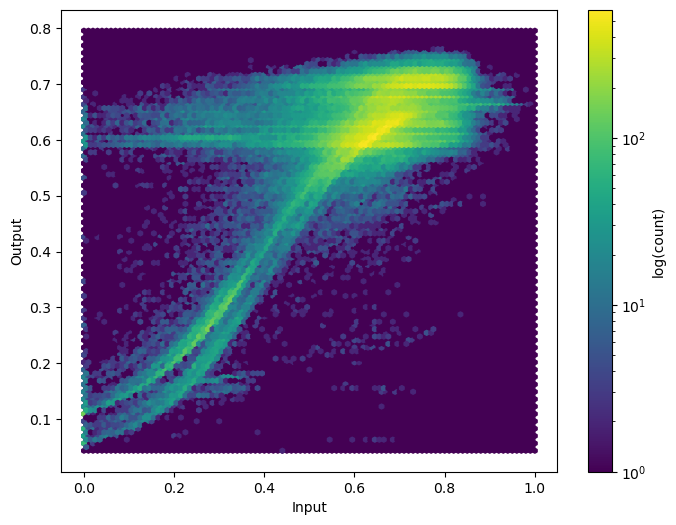

In [120]:
#Plot input vs output
#run through this to check it works with reset kernal!
data_analysis.plot_hexbin_log_frequency(Input_data[:,10], Output_data[:, 10] , xlabel='Input', ylabel='Output', title='')

# Test Trained Model

In [121]:
#import test data as numpy array 
Testing_data = np.loadtxt('testing_data2.csv',delimiter = ',')

## Preprocess Test data

In [122]:
#seperate categorical and continuous

categorical_data_test = np.delete(Testing_data, 5, axis=1)
x6_test = Testing_data[:, 5]

In [123]:
#Preprocess Categorical Data

#apply even spacing
mapped_test = preprocessor.map_unique_values_to_columns(categorical_data_test)

#normalise 
mapped_min_max_test = preprocessing.min_max(mapped_test)

#cluster with same centroids used for training data 
clustered_test = Cluster.kmeans_clustering_with_distances_new_data(centroids, mapped_min_max_test) 

#add min max to cluster number
normalised_clustered_test = preprocessing.min_max_odd_columns(clustered_test)

print(normalised_clustered_test)


[[0.44444444 0.05994096 0.44444444 ... 0.18829525 0.11111111 0.18048669]
 [0.44444444 0.04886089 0.88888889 ... 0.07682226 0.66666667 0.07016924]
 [0.33333333 0.24084341 0.22222222 ... 0.16825198 0.66666667 0.21911494]
 ...
 [0.44444444 0.08959522 0.88888889 ... 0.26195695 0.66666667 0.29681455]
 [0.22222222 0.18350804 0.33333333 ... 0.08706682 0.88888889 0.18426231]
 [0.22222222 0.18350804 0.33333333 ... 0.08231842 0.88888889 0.16067308]]


In [124]:
#Preprocess continuous data

log_x6_test = np.log10(x6_test)
x6_logged_normalized_test = preprocessing.min_max(log_x6_test)



In [125]:
Input_data_test = np.column_stack((normalised_clustered_test, x6_logged_normalized_test))

## AutoEncoder on Test Data

In [126]:
latent_space_representation_test = AutoEncoder.encoder.predict(Input_data_test)

Output_data_test = AutoEncoder.decoder.predict(latent_space_representation_test)

1563/1563 [==============================] - 1s 905us/step


## Find Anomalies using Training Data Threshold

In [127]:
Reconstruction_loss = np.mean(np.square(Input_data_test - Output_data_test), axis = 1)

In [128]:
anomaly_truth = Reconstruction_loss > Threshold

anomaly_indices = np.where(anomaly_truth)[0]

anomalies = Input_data_test[anomaly_truth]

print("Anomalies:")
print(anomalies)

print("Indices of anomalies in Test_data:")
print(anomaly_indices)

print("Number of anomalies:", len(anomalies))

Anomalies:
[[0.33333333 0.30532399 0.77777778 ... 0.11111111 0.27190617 0.62359588]
 [0.22222222 0.76673138 0.77777778 ... 0.33333333 0.38043872 0.71042675]
 [0.77777778 0.55328006 0.77777778 ... 0.33333333 0.33012288 0.68389402]
 ...
 [0.33333333 0.14603581 0.22222222 ... 0.66666667 0.2499829  0.02497879]
 [0.22222222 0.36175523 0.66666667 ... 0.88888889 0.48556398 0.64271086]
 [0.         0.47425147 0.66666667 ... 0.77777778 0.57019665 0.54419644]]
Indices of anomalies in Test_data:
[  143   324   348   435   714   741  1021  1029  1043  1059  1096  1244
  1311  1459  1497  1508  1554  1602  1695  2039  2087  2110  2158  2204
  2367  2381  2387  2632  2643  2870  2923  2953  3129  3169  3224  3297
  3391  3647  3652  3675  3684  3736  3795  3812  3884  4020  4358  4360
  4389  4395  4573  4711  4741  4853  4893  4981  5030  5125  5137  5272
  5308  5314  5429  5439  5478  5523  5688  5737  5742  5863  5865  5887
  5910  5971  6031  6037  6054  6188  6215  6270  6290  6314  6325  6345

## Test Data Analysis

In [129]:
Test_grad, Test_grad_average = Analyse.calculate_average_grad(Input_data_test, Output_data_test)
print(Test_grad_average)

0.7506855402254345


In [130]:
Test_R2, Test_R2_average = Analyse.calculate_r_square(Input_data_test, Output_data_test)
print(Test_R2_average)

0.7606486192173563


## Compare to George IDs

In [131]:
df = pd.read_csv('George_Anomalies.csv')
George_IDs = df['id']
array_of_values = np.array(George_IDs, dtype=int)
print(array_of_values)

[  324   348   422   816  1186  1351  1497  1513  1532  2136  2364  2367
  2643  2743  2869  2923  3135  3373  3652  3720  3791  3792  3844  4002
  4087  4250  4336  4360  4741  4791  4853  4887  5008  5100  5314  5668
  5790  5798  5863  5969  5973  6062  6210  6218  6236  6264  6324  6397
  6508  6825  6831  6955  7037  7078  7094  7451  7496  7600  7627  7824
  7903  7968  8185  8248  8263  8421  8794  8988  9136  9152  9276  9314
  9325  9546  9593  9650  9847 10054 10077 10331 10347 10567 10643 10702
 10883 10935 10961 11130 11191 11198 11235 11558 11840 11948 11958 12036
 12486 12599 12700 12846 12946 13351 13388 13619 13717 13736 14036 14066
 14206 14558 14628 15318 15394 15676 15921 16204 16212 16226 16292 16350
 16615 16785 17279 17308 17646 17651 17879 17957 18618 18970 19007 19196
 19288 19302 19375 19408 19487 19505 20206 20366 20749 21072 21411 21467
 21508 21693 21830 22362 22553 22612 22757 22996 23351 23609 23731 23819
 23944 24077 24080 24418 24531 24598 24602 24865 24

In [132]:
# Calculate the intersection of the two arrays
intersection = np.intersect1d(George_IDs, anomaly_indices)

# Get the number of values shared
shared_count = len(intersection)

print("Number of shared values:", shared_count)

Number of shared values: 59


In [ ]:
#different to before update why?

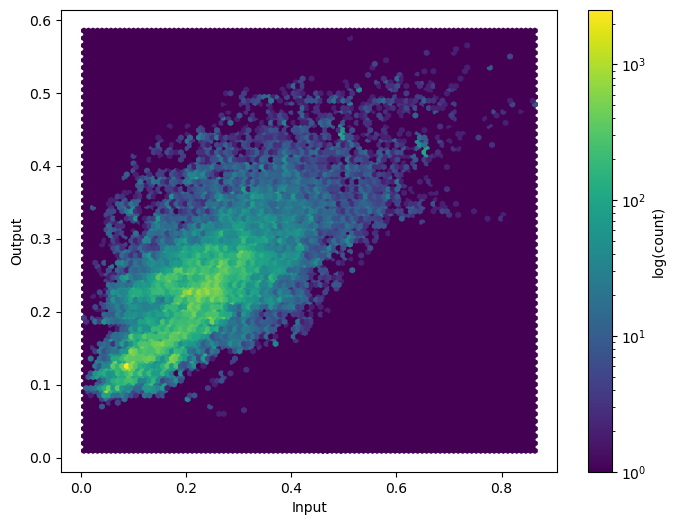

In [154]:
import keras

print(keras.__version__)

3.0.5


In [155]:
import tensorflow as tf

print(tf.__version__)

2.16.1
